**COMPUTER VISION ON IMAGE CLASSIFICATION OF FOOD**

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import re
import os

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DONT RUN THIS CODE AGAIN
#It was used to rename files not properly saved
# for filename in os.listdir(data_path):
#   if re.search(r"\b(img)", filename, re.IGNORECASE):
#     src = os.path.join(data_path, filename)
#     new_name = f"soup{filename}"
#     os.rename(src, os.path.join(data_path, new_name))
#     print(src)

#### Data Labelling

In [6]:
#define a regular expression for each category
swallow_pattern = r"\b(amala|afang|egusi|soup|stew|swallow|efo riro|ewedu|pounded|poundo)"
rice_pattern = r"\b(jollof|fried|rice|fried rice|ofada)"
beans_pattern = r"\b(beans)"
chicken_pattern = r"\b(chicken)"
spaghetti_pattern = r"\b(spaghetti|spag|Macaroni|Pasta|cream coconut|creamy coconut|easy carbonara)"
yam_pattern = r"\b(yam)"
fruit_pattern = r"\b(soursop|tangerine|apples|lemon|cucumber|oranges|african pear|watermelon|banana|dragon fruit|cashew-fruit|cabbage|prickly pears|mangosteen|avocado|cherry|starfruit|papaya|apple|orange|banana|mango|strawberry|grapes|pineapple|guava|pomegranate|kiwi)"
soft_drinks_pattern = r"\b(coke|fanta|pepsi|schwepps|mirinda|bigi|seven up|sprite|mountain dew|smoov|drink|drinks|soft drink)"

# Define a function to categorize food based on the filename
def categorize_food(item):
    if re.search(yam_pattern, item, re.IGNORECASE):
        return 'Yam'
    elif re.search(rice_pattern, item, re.IGNORECASE):
        return 'Rice'
    elif re.search(beans_pattern, item, re.IGNORECASE):
        return 'Beans'
    elif re.search(chicken_pattern, item, re.IGNORECASE):
        return 'Chicken Dish'
    elif re.search(swallow_pattern, item, re.IGNORECASE):
        return 'Swallow'
    elif re.search(spaghetti_pattern, item, re.IGNORECASE):
        return 'Spaghetti'
    elif re.search(fruit_pattern, item, re.IGNORECASE):
        return 'Fruit'
    elif re.search(soft_drinks_pattern, item, re.IGNORECASE):
        return 'Drinks'
    else:
        return 'Other'

In [7]:
#where all the files are located
data_path = '/content/drive/MyDrive/3MTT Data'

In [8]:
#looping through all the filename to get the category
data = []

for filename in os.listdir(data_path):
  category = categorize_food(filename)
  data.append([filename, category])

In [9]:
#converting it to a dataframe
df = pd.DataFrame(data, columns = ['Filename', 'Category'])

In [10]:
df.head()

,Filename,Category
0,Peppered chicken.jpg,Chicken Dish
1,Cream Coconut Rice.jpg,Rice
2,Asun.jpg,Other
3,Shredded Chicken.jpg,Chicken Dish
4,Creamy Coconut.jpg,Spaghetti


In [11]:
df.Category.value_counts()

Rice            83
Spaghetti       76
Swallow         73
Yam             60
Fruit           42
Other           34
Drinks          29
Chicken Dish     4
Beans            4
Name: Category, dtype: int64

In [ ]:
# df.query('Category == "Other"')

In [12]:
df.Category.unique()

array(['Chicken Dish', 'Rice', 'Other', 'Spaghetti', 'Swallow', 'Beans',
       'Fruit', 'Yam', 'Drinks'], dtype=object)

In [13]:
desired_categories = ['Spaghetti', 'Yam', 'Rice', 'Beans', 'Chiken Dish', 'Fruit', 'Swallow', 'Drinks']

In [14]:
#pick only selected catergories to train on
new_df = df[df.Category.isin(desired_categories)]
new_df.shape

(367, 2)

In [15]:
new_df.Category.unique()

array(['Rice', 'Spaghetti', 'Swallow', 'Beans', 'Fruit', 'Yam', 'Drinks'],
      dtype=object)

**Image PreProcessing**

In [16]:
#necessary libraries
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
images_dir = data_path

In [18]:
# data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

In [19]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed = 42)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed = 42)

Found 255 validated image filenames belonging to 7 classes.
Found 63 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 49 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 49 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


In [20]:
train_generator

**Model Configuration**

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout

In [22]:
#the CNN configuration
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

In [24]:
#compiling the model before training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the custom model**

In [25]:
#training the model
history = model.fit(
    train_generator,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
16/16 [==============================] - 94s 6s/step - loss: 2.1057 - accuracy: 0.1804 - val_loss: 1.8838 - val_accuracy: 0.4921
Epoch 2/10
16/16 [==============================] - 22s 1s/step - loss: 1.8744 - accuracy: 0.2157 - val_loss: 1.9114 - val_accuracy: 0.0635
Epoch 3/10
16/16 [==============================] - 22s 1s/step - loss: 1.7599 - accuracy: 0.2588 - val_loss: 2.0131 - val_accuracy: 0.1587
Epoch 4/10
16/16 [==============================] - 20s 1s/step - loss: 1.7454 - accuracy: 0.2745 - val_loss: 2.1084 - val_accuracy: 0.1270
Epoch 5/10
16/16 [==============================] - 30s 2s/step - loss: 1.7115 - accuracy: 0.3020 - val_loss: 1.8873 - val_accuracy: 0.1429
Epoch 6/10
16/16 [==============================] - 22s 1s/step - loss: 1.6099 - accuracy: 0.3882 - val_loss: 1.7993 - val_accuracy: 0.2222
Epoch 7/10
16/16 [==============================] - 22s 1s/step - loss: 1.5682 - accuracy: 0.3843 - val_loss: 1.7412 - val_accuracy: 0.2540
Epoch 8/10
16/16 [==

**Model Evaluation**

In [28]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {int(val_accuracy* 100)}%")


4/4 [==============================] - 3s 630ms/step - loss: 1.8403 - accuracy: 0.2063
Validation loss: 1.840260624885559
Validation accuracy: 20%


In [29]:
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image_category(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    img_preprocessed = img_array_expanded_dims / 255.0

    # Make a prediction
    prediction = model.predict(img_preprocessed)

    # Assuming your model's classes are accessible via train_generator.class_indices
    # which is a dictionary mapping class names to their indices.
    # We need to invert this dictionary to map indices back to class names.
    label_map = dict((v, k) for k, v in train_generator.class_indices.items())

    # Find the index of the maximum score in the prediction array
    predicted_class_index = np.argmax(prediction, axis=1)
    predicted_class_name = label_map[predicted_class_index[0]]

    return predicted_class_name

# # Example usage
# image_path = 'path/to/your/image.jpg'
# predicted_category = predict_image_category(image_path, model)
# print(f"The predicted category is: {predicted_category}")


In [30]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def display_image_with_prediction(image_path, model):
    # Predict the image category
    predicted_category = predict_image_category(image_path, model)

    # Load the image for display
    img = image.load_img(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks

    # Add a rectangle for the text background, if desired
    plt.gca().add_patch(Rectangle((0, 0), 120, 30, color='white'))

    # Add the predicted category text
    plt.text(5, 20, predicted_category, color='red', weight='bold', fontsize=20)

    plt.show()


In [31]:
#TO SAVE YOUR MODEL

# new_model = data_path + '/food_model.h5'

1/1 [==============================] - 0s 82ms/step


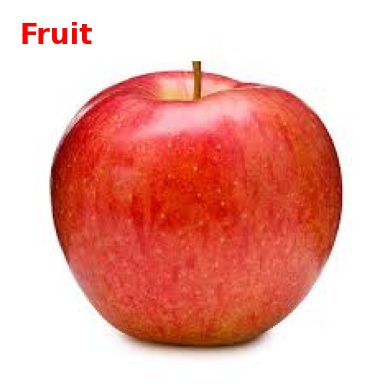

In [35]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Apple - Michael Kanu.jpg'
display_image_with_prediction(image_path, model)


1/1 [==============================] - 0s 49ms/step


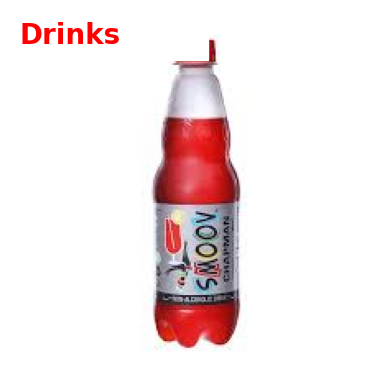

In [42]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Smoov - Michael Kanu.jpg'
display_image_with_prediction(image_path, model)


1/1 [==============================] - 0s 53ms/step


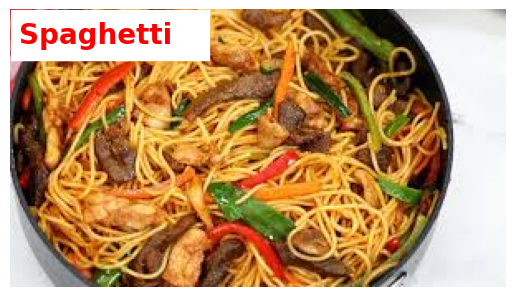

In [43]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Sphagetti 5 - Michael Kanu.jpg'
display_image_with_prediction(image_path, model)


1/1 [==============================] - 0s 33ms/step


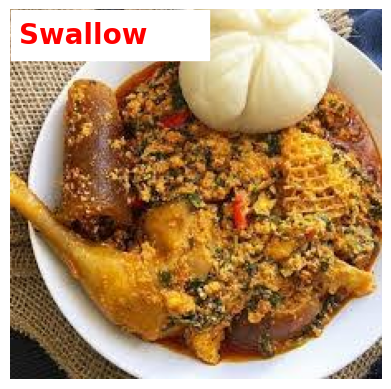

In [55]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Egusi soup - Michael Kanu.jpg'
display_image_with_prediction(image_path, model)


1/1 [==============================] - 0s 34ms/step


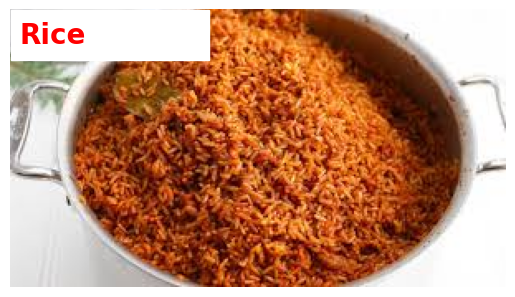

In [58]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/jollof rice 8 - Michael Kanu.jpg'
display_image_with_prediction(image_path, model)


In [ ]:
# #saving our custom trained model to 3MTT folder
# model_save_path = data_path + '/food_model.h5'
# model.save(model_save_path)

# model_save_path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/3MTT Data/food_model.h5'

**USING A PRE-TRAINED MODEL**

In [60]:
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# Load the base INCEPTION v3 model, excluding its top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top for our specific classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# This is the model we will train
new_model = Model(inputs=base_model.input, outputs=predictions)

# Calculate class weights to address class imbalance
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                classes= np.unique(train_generator.classes),
                y= train_generator.classes)

class_weights = dict(enumerate(class_weights))

# Compile the model
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)




87910968/87910968 [==============================] - 1s 0us/step


In [62]:
# data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

In [63]:
# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    seed = 42)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=new_df,
    directory=images_dir,  # replace with your actual images directory
    x_col='Filename',
    y_col='Category',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    seed = 42)

Found 255 validated image filenames belonging to 7 classes.
Found 63 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 49 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 49 invalid image filename(s) in x_col="Filename". These filename(s) will be ignored.
  warnings.warn(


In [64]:
# Train the model
history = new_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    #class_weight=class_weights,
    callbacks=[early_stopping])

Epoch 1/10
16/16 [==============================] - 50s 3s/step - loss: 1.5582 - accuracy: 0.4314 - val_loss: 1.2174 - val_accuracy: 0.5079
Epoch 2/10
16/16 [==============================] - 41s 3s/step - loss: 0.7261 - accuracy: 0.7451 - val_loss: 0.9189 - val_accuracy: 0.6984
Epoch 3/10
16/16 [==============================] - 42s 3s/step - loss: 0.5075 - accuracy: 0.8588 - val_loss: 0.7412 - val_accuracy: 0.7460
Epoch 4/10
16/16 [==============================] - 41s 3s/step - loss: 0.3872 - accuracy: 0.8667 - val_loss: 1.0395 - val_accuracy: 0.5714
Epoch 5/10
16/16 [==============================] - 44s 3s/step - loss: 0.3496 - accuracy: 0.8706 - val_loss: 0.8751 - val_accuracy: 0.6508
Epoch 6/10
16/16 [==============================] - 44s 3s/step - loss: 0.2607 - accuracy: 0.9020 - val_loss: 0.6537 - val_accuracy: 0.7302
Epoch 7/10
16/16 [==============================] - 47s 3s/step - loss: 0.2811 - accuracy: 0.8902 - val_loss: 0.5624 - val_accuracy: 0.8095
Epoch 8/10
16/16 [==

In [65]:
# Evaluate the model on the validation set
val_loss, val_accuracy = new_model.evaluate(validation_generator)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {int(val_accuracy* 100)}%")


4/4 [==============================] - 9s 2s/step - loss: 0.8922 - accuracy: 0.6349
Validation loss: 0.8922491669654846
Validation accuracy: 63%


1/1 [==============================] - 0s 129ms/step


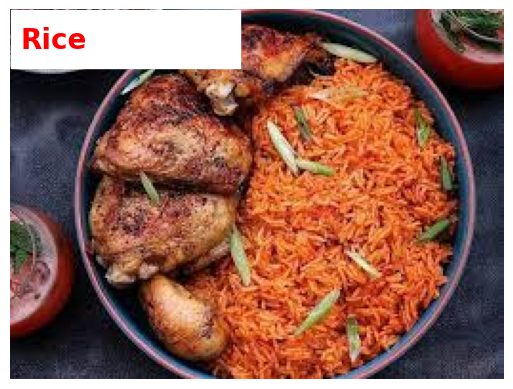

In [77]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/jollof rice 6 - Michael Kanu.jpg'
display_image_with_prediction(image_path, new_model) #change model to new_model after retraining


# download.jpeg

1/1 [==============================] - 0s 129ms/step


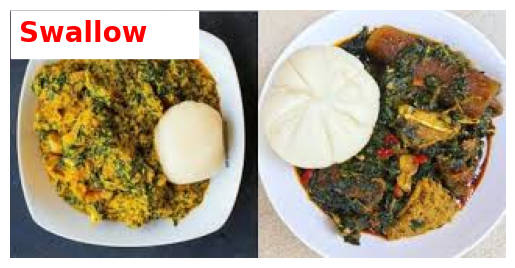

In [73]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Efo riro - Michael Kanu.jpg'
display_image_with_prediction(image_path, new_model) #change model to new_model after retraining


# download.jpeg

1/1 [==============================] - 0s 121ms/step


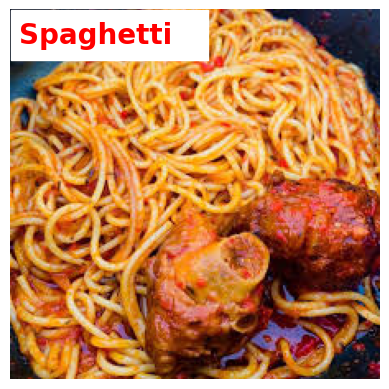

In [76]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Sphagetti 7 - Michael Kanu.jpg'
display_image_with_prediction(image_path, new_model)


1/1 [==============================] - 0s 125ms/step


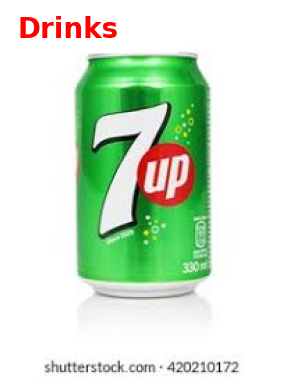

In [78]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Seven up - Michael Kanu.jpg'
display_image_with_prediction(image_path, new_model)


1/1 [==============================] - 0s 122ms/step


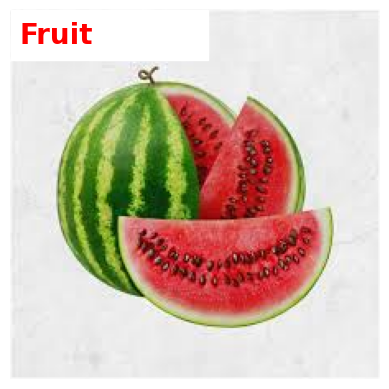

In [79]:
# Example usage
image_path = '/content/drive/MyDrive/3MTT Data/Watermelon - Michael Kanu.jpg'
display_image_with_prediction(image_path, new_model)


In [ ]:
# # #saving our custom trained model to 3MTT folder
# model_save_path = data_path + '/food_newmodel.h5'
# new_model.save(model_save_path)

# model_save_path

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/3MTT Data/food_newmodel.h5'